In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt
from baselineNet import kerasNet
import random
import math
import numpy as np
import pandas as pd
import crocoddyl
crocoddyl.switchToNumpyArray()

Using TensorFlow backend.


In [3]:
#%%file cost_trajectory.py
def data(nTraj:int = 1000,
         thetaVal:bool = False,
         fddp:bool = False
        ):
    model = crocoddyl.ActionModelUnicycle()
    x_data = []
    y_data = []
    
    for _ in range(nTraj):

        if thetaVal:
            initial_config = [random.uniform(-1.99, 1.99), random.uniform(-1.99, 1.99), random.uniform(0.,1.)]
        else:
            initial_config = [random.uniform(-1.99, 1.99), random.uniform(-1.99, 1.99), 0.0]
        model.costWeights = np.matrix([1, 0.3]).T
        problem = crocoddyl.ShootingProblem(np.matrix(initial_config).T, [ model ] * 30, model)
        if fddp:
            ddp = crocoddyl.SolverFDDP(problem)
        else:
            ddp = crocoddyl.SolverDDP(problem)
            
        ddp.solve([], [], 1000)
        if ddp.iter < 1000:
            xs_ = np.array(ddp.xs)
            xs = xs_[1:, :]
            #cost = []
            #for d in ddp.datas():
            #    cost.append(d.cost)
            #cost = np.array(cost).reshape(31,1)
            #state = np.hstack((xs, cost))
            
        y_data.append(xs.ravel())   
        x_data.append(initial_config)
        
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    del model, ddp
    return x_data, y_data
            
            

In [4]:
x_data, y_data  = data(20000)


Using gpu!
X_Train :  (20000, 3)  and Y_Train:  (20000, 90)
Model: "Network1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
Final (Dense)                (None, 90)                5850      
Total params: 14,426
Trainable params: 14,426
Non-trainable params: 0
_________________________________________________________________
None


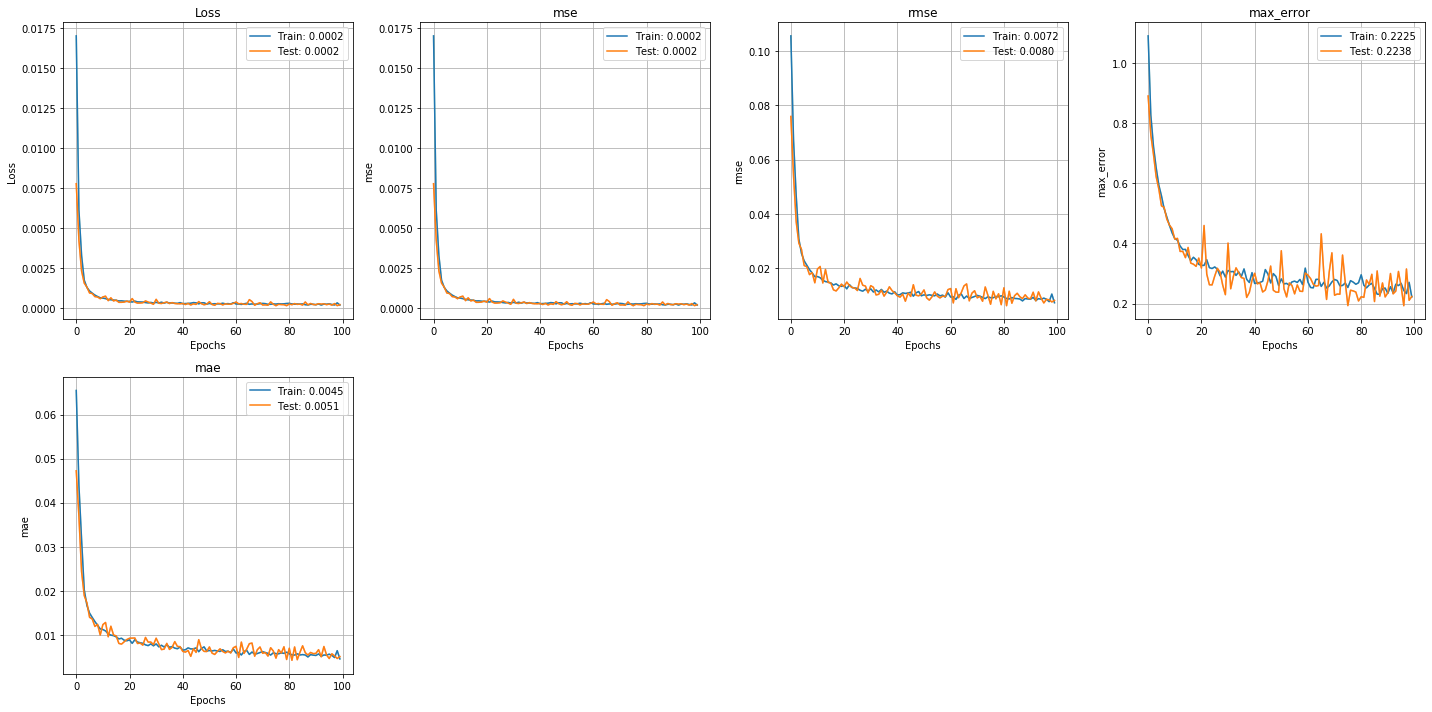

In [5]:
net = kerasNet(x_data,
             y_data,
             NUNITS_INPUT = 64,
             NUNITS = 64,
             NHIDDEN = 2,
             lr = 1e-3,
             EPOCHS = 100,
             BATCHSIZE = 64,
             validation_split = 0.1,
             VERBOSE = 0,
             optimizer = "adam",
             loss = ['mean_squared_error'],
             use_gpu = True,
             saveModel = False,
             plot_results = True,
             baseline = False    )

In [6]:
def point(h:float= 0., k:float = 0., r:int = 2):
    """
    Generate random points from the circumference of a circle
    (h, k) -> center
    r  = radius
    """
    theta = random.random() * 2 * np.pi
    return h + np.cos(theta) * r, k + np.sin(theta) * r

#x, y = point()
#initial_state = [-1.5, -2., 0] 
initial_state = [random.uniform(-2, 2), random.uniform(-2, 2), 0.0]


model = crocoddyl.ActionModelUnicycle()

x_test = np.array(initial_state).reshape(1, -1)
y_pred = net.predict(x_test)
warm = y_pred.reshape(30, 3)
init_xs = []
init_xs.append(np.array(initial_state))
for i in warm:
    a = np.array(i)
    init_xs.append(a)

    
# Warmstarting    
model.costWeights = np.matrix([1, 0.3]).T
problem = crocoddyl.ShootingProblem(np.matrix(initial_state).T, [ model ] * 30, model)
ddp = crocoddyl.SolverDDP(problem)
ddp.solve(init_xs, [], 1000)
ddp_xs = np.array(ddp.xs)
print("Warmstarted " , ddp.iter)

#ColdStart
del model, ddp, problem
model2 = crocoddyl.ActionModelUnicycle()
model2.costWeights = np.matrix([1, 0.3]).T
problem2 = crocoddyl.ShootingProblem(np.matrix(initial_state).T, [ model2 ] * 30, model2)
ddp2 = crocoddyl.SolverDDP(problem2)
ddp2.solve([], [], 1000)
ddp2_xs = np.array(ddp2.xs)
print("ColdStarted" ,ddp2.iter)

Warmstarted  18
ColdStarted 18


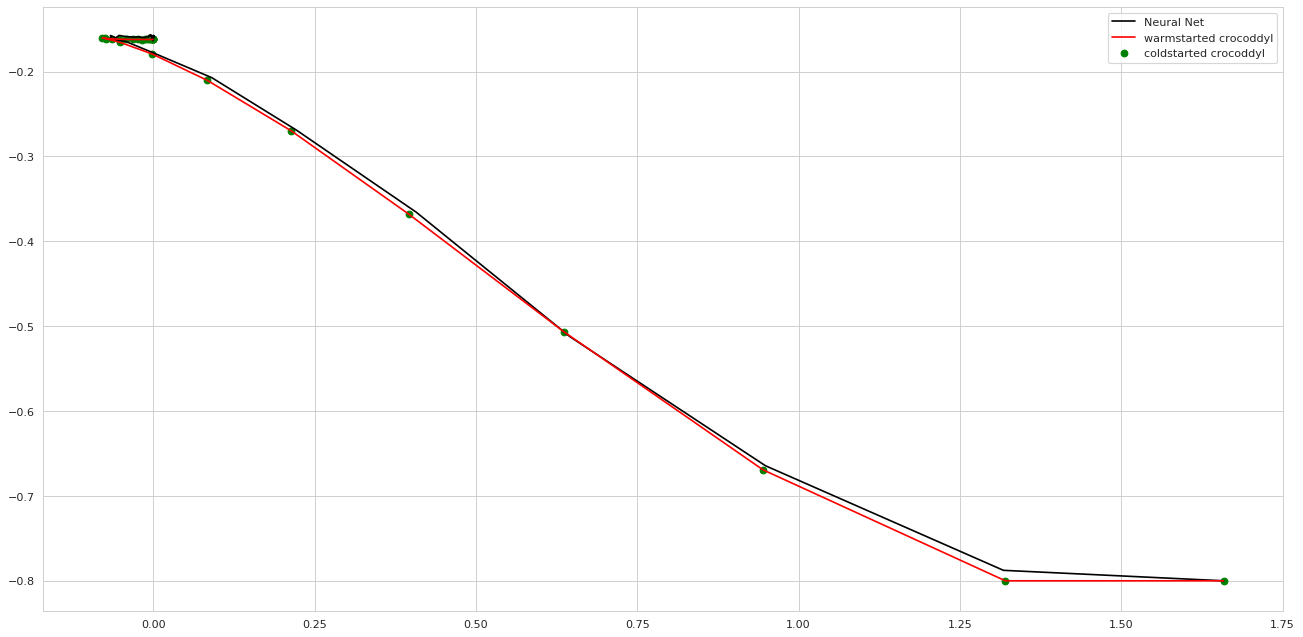

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 80
plt.figure(figsize=(20, 10))
plt.axis(aspect='image')
#plt.xlim(-2.1, 2.1)
#plt.ylim(-2.1, 2.1)
init_xs = np.array(init_xs)
plt.plot(init_xs[:,0], init_xs[:,1], c = 'black', label="Neural Net")
plt.plot(ddp_xs[:,0], ddp_xs[:,1], c = 'red', label = 'warmstarted crocoddyl')
plt.scatter(ddp2_xs[:,0], ddp2_xs[:,1], c = 'green', label = 'coldstarted crocoddyl')
plt.legend()

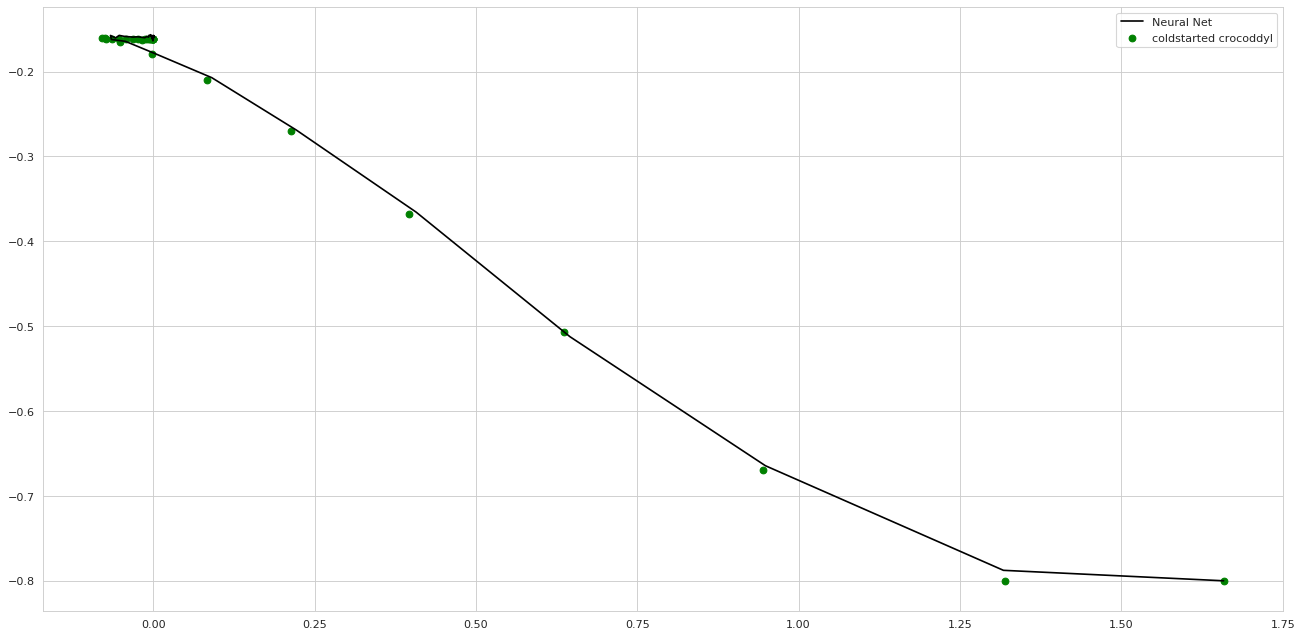

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(init_xs[:,0], init_xs[:,1], c = 'black', label="Neural Net")
plt.scatter(ddp2_xs[:,0], ddp2_xs[:,1], c = 'green', label = 'coldstarted crocoddyl')
plt.legend()

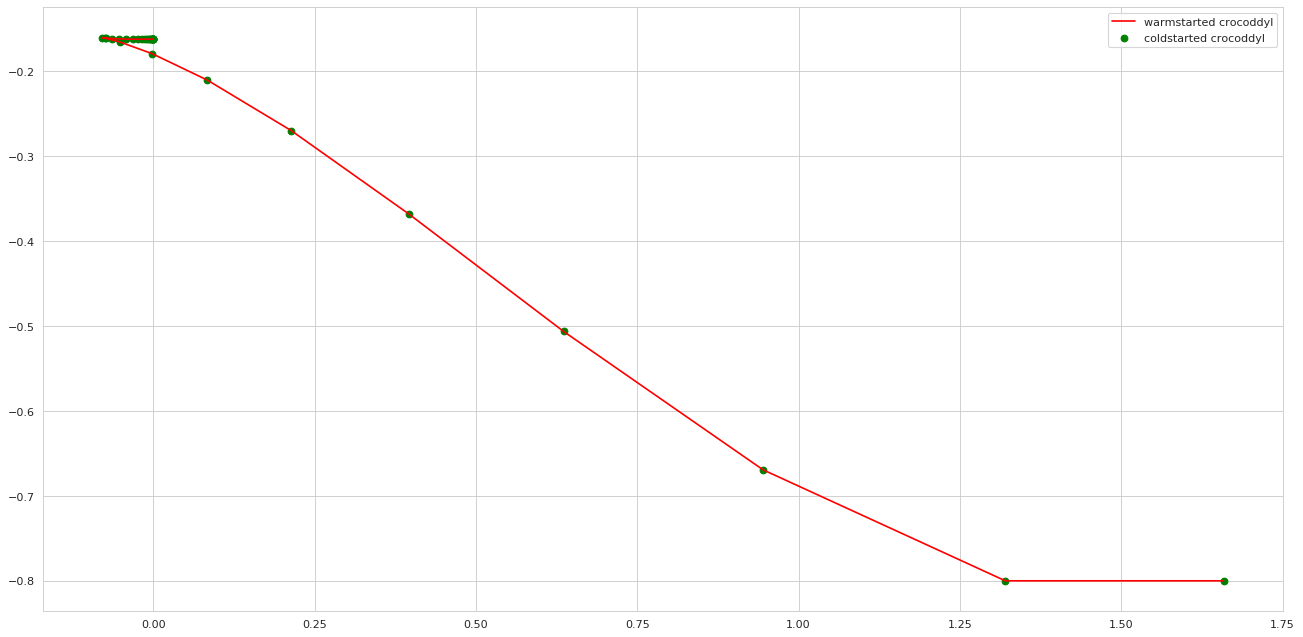

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(ddp_xs[:,0], ddp_xs[:,1], c = 'red', label = 'warmstarted crocoddyl')
plt.scatter(ddp2_xs[:,0], ddp2_xs[:,1], c = 'green', label = 'coldstarted crocoddyl')
plt.legend()

In [56]:
initial_state = [random.uniform(-2, 2), random.uniform(-2, 2), 0.0]


model = crocoddyl.ActionModelUnicycle()

x_test = np.array(initial_state).reshape(1, -1)
y_pred = net.predict(x_test)
warm = y_pred.reshape(30, 3)
init_xs = []
init_xs.append(np.array(initial_state))
for i in warm:
    a = np.array(i)
    init_xs.append(a)

    
# Warmstarting    
model.costWeights = np.matrix([1, 0.3]).T
problem = crocoddyl.ShootingProblem(np.matrix(initial_state).T, [ model ] * 30, model)
ddp = crocoddyl.SolverDDP(problem)
ddp.solve(init_xs, [], 1000)
ddp_xs = np.array(ddp.xs)
print("Warmstarted " , ddp.iter)

#ColdStart

model2 = crocoddyl.ActionModelUnicycle()
model2.costWeights = np.matrix([1, 0.3]).T
problem2 = crocoddyl.ShootingProblem(np.matrix(initial_state).T, [ model2 ] * 30, model2)
ddp2 = crocoddyl.SolverDDP(problem2)
ddp2.solve(ddp.xs, [], 1000)
ddp2_xs = np.array(ddp2.xs)
print("ColdStarted" ,ddp2.iter)

Warmstarted  39
ColdStarted 39
